## 1. 算法概述

简单的说，k-近邻算法采用测量不同特征值之间的距离方法进行分类。
> 优点：精度高、对异常值不敏感、无数据输入假定

> 缺点：计算复杂度高、空间复杂度高

> 适用数据范围：数值型和标称型

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import operator # 用于字典排序
import os

In [6]:
# 构造数据集并返回
def create_dataset():
    group = np.array([[1.0, 1.1], [1.0, 1.0], [0, 0], [0, 0.1]])
    labels = ['A', 'A', 'B', 'B']
    return group, labels

In [11]:
group, labels = create_dataset()
group, labels

(array([[ 1. ,  1.1],
        [ 1. ,  1. ],
        [ 0. ,  0. ],
        [ 0. ,  0.1]]), ['A', 'A', 'B', 'B'])

In [10]:
# k-近邻算法
def classify(inX, dataSet, labels, k):
    """
    inX: 待分类数据集
    dataSet: 原始数据集
    labels: 原始数据集标签
    k：个数
    """
    dataSetSize = dataSet.shape[0]
    diffMat = np.tile(inX, (dataSetSize, 1)) - dataSet # 纵向复制
    distance = np.sum(diffMat**2, axis=1)**0.5
    sortedDistIndex = distance.argsort()
    classCount = {}
    for i in range(k):
        voteIlabel = labels[sortedDistIndex[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

In [15]:
# test
classify([0, 0], group, labels, 3)

'B'

## 2. 示例：使用k-近邻算法改进约会网站的配对效果

### 2.1 准备数据：从文本中解析

In [3]:
def file2matrix(filename):
    with open(filename) as f:
        arrayLines = f.readlines()
        numOfLines = len(arrayLines)
        returnMat = np.zeros((numOfLines, 3))
        classLableVector = []
        index = 0
        for line in arrayLines:
            line = line.strip() # 去除结尾换行
            line  = line.split('\t')
            returnMat[index, :] = line[0:3]
            classLableVector.append(int(line[-1]))
            index += 1
        return returnMat, classLableVector

In [4]:
datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
datingDataMat

array([[  4.09200000e+04,   8.32697600e+00,   9.53952000e-01],
       [  1.44880000e+04,   7.15346900e+00,   1.67390400e+00],
       [  2.60520000e+04,   1.44187100e+00,   8.05124000e-01],
       ..., 
       [  2.65750000e+04,   1.06501020e+01,   8.66627000e-01],
       [  4.81110000e+04,   9.13452800e+00,   7.28045000e-01],
       [  4.37570000e+04,   7.88260100e+00,   1.33244600e+00]])

In [5]:
datingLabels[:20]

[3, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3]

### 2.2 分析数据: 使用matplotlib创建散点图

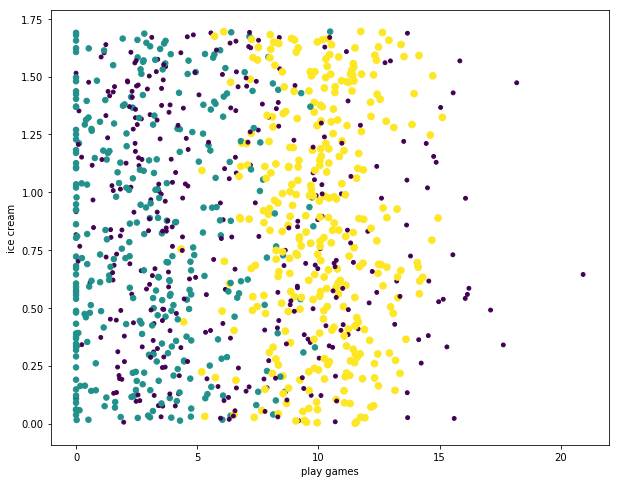

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(datingDataMat[:, 1], datingDataMat[:, 2], s=15.0*np.array(datingLabels), c=15.0*np.array(datingLabels))
plt.xlabel('play games')
plt.ylabel('ice cream')
plt.show()

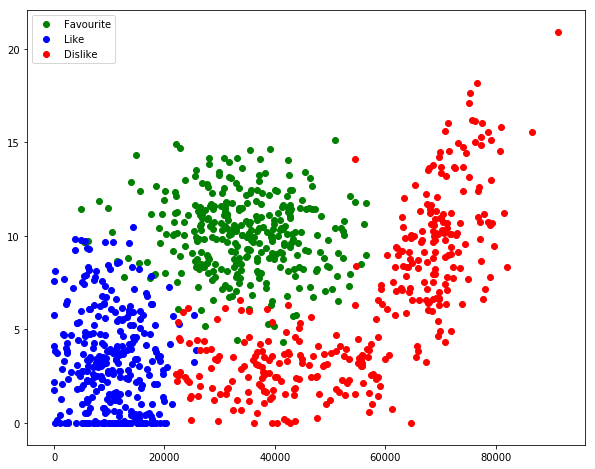

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
favourite = datingDataMat[np.array(datingLabels) == 3]
like = datingDataMat[np.array(datingLabels) == 2]
dislike = datingDataMat[np.array(datingLabels) == 1]
tempLabels = np.array(datingLabels).copy()
ax.scatter(favourite[:, 0], favourite[:, 1], c='g', label='Favourite')
ax.scatter(like[:, 0], like[:, 1], c='b', label='Like')
ax.scatter(dislike[:, 0], dislike[:, 1], c='r', label='Dislike')
plt.legend(loc='best')
plt.show()

### 2.3 准备数据：归一化数值

数据归一化的原因是要统一量纲，避免不同量纲属性所带来的额外影响。

In [8]:
def autoNorm(dataSet):
    minVals = dataSet.min(axis=0)
    maxVals = dataSet.max(axis=0)
    ranges = maxVals - minVals
    # get the shape
    m, n = dataSet.shape
    normDataSet = np.zeros((m, n))
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    normDataSet = normDataSet / np.tile(ranges, (m, 1))
    return normDataSet, ranges, minVals

In [9]:
normMat, ranges, minVals = autoNorm(datingDataMat)
normMat

array([[ 0.44832535,  0.39805139,  0.56233353],
       [ 0.15873259,  0.34195467,  0.98724416],
       [ 0.28542943,  0.06892523,  0.47449629],
       ..., 
       [ 0.29115949,  0.50910294,  0.51079493],
       [ 0.52711097,  0.43665451,  0.4290048 ],
       [ 0.47940793,  0.3768091 ,  0.78571804]])

### 2.4 测试算法

一般选取数据集的90%作为训练集，剩下10%作为测试集，错误分类的数量/测试集的大小=错误率

In [13]:
def datingClassTest():
    hoRatio = 0.1
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    m, n = normMat.shape
    numTestVecs = int(m * hoRatio)
    errorCount = 0
    for i in range(numTestVecs):
        classifierResult = classify(normMat[i, :], normMat[numTestVecs:m, :], datingLabels[numTestVecs:m], 3)
        print('the classifier came back with: {0}, the real answer is: {1}'.format(classifierResult, datingLabels[i]))
        if classifierResult != datingLabels[i]:
            errorCount += 1
    print('the total error rate is: {0}'.format(errorCount/float(numTestVecs)))

In [14]:
datingClassTest()

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

### 2.5 使用算法：构建完整可用系统

In [15]:
def classifyPerson():
    resultList = ['not at all', 'in small does', 'in large does']
    percentRate = float(input('percentage of time spent playing video games?'))
    ffMiles = float(input('frequent flier miles earned per years?'))
    iceCream = float(input('liters of ice cream consumed per year?'))
    datingDataMat, datingLabels = file2matrix('datingTestSet2.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    inArr = np.array([ffMiles, percentRate, iceCream])
    classifierResult = classify((inArr-minVals)/ranges, normMat, datingLabels, 3)
    print('you probably like this person: ', resultList[classifierResult-1])

In [16]:
classifyPerson()

percentage of time spent playing video games?10
frequent flier miles earned per years?10000
liters of ice cream consumed per year?0.5
you probably like this person:  in small does


## 3. 示例：手写识别系统

### 3.1 准备数据：将图像转换为测试向量

In [19]:
# 将图像扁平化处理
def img2vector(filename):
    returnVect = np.zeros((1, 1024))
    with open(filename) as f:
        for i in range(32):
            line = f.readline()
            for j in range(32):
                returnVect[0, 32*i+j] = int(line[j])
    return returnVect

In [20]:
img2vector('digits/testDigits/0_13.txt')

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### 3.2 测试算法：使用k-近邻算法识别手写数字

In [22]:
def handwritingClassTest():
    hwLabels = []
    trainingFileList = os.listdir('digits/trainingDigits')
    m = len(trainingFileList)
    trainingMat = np.zeros((m, 1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        hwLabels.append(classNumStr)
        trainingMat[i, :] = img2vector('digits/trainingDigits/' + fileNameStr)
    testFileList = os.listdir('digits/testDigits')
    errorCount = 0.0
    mTest = len(testFileList)
    for i in range(mTest):
        fileNameStr = testFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        vectorUnderTest = img2vector('digits/testDigits/' + fileNameStr)
        classifierResult = classify(vectorUnderTest, trainingMat, hwLabels, 3)
        print('the classifier came back with: {0}, the real answer is: {1}'.format(classifierResult, classNumStr))
        if classifierResult != classNumStr:
            errorCount += 1
    print('\n the total number of errors is: {0}'.format(errorCount))
    print('\nthe total error rate is: {0}'.format(errorCount/float(mTest)))

In [23]:
handwritingClassTest()

the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answer is: 0
the classifier came back with: 0, the real answe

the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answe

the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answer is: 4
the classifier came back with: 4, the real answe

the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answer is: 6
the classifier came back with: 6, the real answe

the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 7, the real answer is: 7
the classifier came back with: 8, the real answer is: 8
the classifier came back with: 8, the real answer is: 8
the classifier came back with: 8, the real answer is: 8
the classifier came back with: 6, the real answer is: 8
the classifier came back with: 8, the real answer is: 8
the classifier came back with: 8, the real answer is: 8
the classifier came back with: 8, the real answe

the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 7, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answer is: 9
the classifier came back with: 9, the real answe

> 总结： k-近邻算法是分类数据种最简单最有效的算法，但是效率低下，而且需要大量的存储空间，另外，该算法无法给出数据的基础结构信息。